In [7]:
include("MDPModelFunctions.jl")
using StatsBase

N_Quanta = 5
N_Objects = 3
using PythonPlot
using Random

In [2]:
function sample_state(N_Objects, N_Quanta)
    
    # Step 1: Generate N-1 random integers
    random_integers = rand(1:N_Quanta, N_Objects-1)

    # Step 2: Sort the generated integers
    sort!(random_integers)
    
    # Step 3: Calculate the differences
    differences = [random_integers[1]; diff(random_integers); N_Quanta - random_integers[end]]

    return shuffle(differences)
    
end

function get_Pol_onestep_R(s, object_probe_probs, per_timestep_probe_prob, epsilon) # also get the policy?
    
    # could this be biased?
    
    N_Objects = length(s)

    
    legal_actions = findall(s.>0)
    N_legal_actions = length(legal_actions)
    Q = zeros(N_legal_actions)

    for a_idx in 1:N_legal_actions
    # a_idx = 1

        A = legal_actions[a_idx]

        possible_S_prime, prob_S_prime = get_possible_s_prime_and_probs(s,A)
        possible_R_prime = [get_state_reward(this_s, object_probe_probs, per_timestep_probe_prob) for this_s in possible_S_prime]

        Q[a_idx] = prob_S_prime'*possible_R_prime # just look to the next state
    end
    
    Q = round.(Q,digits=6)

    max_val = maximum(Q)

    max_Q_idxs = findall(Q .== max_val)
    max_actions = legal_actions[max_Q_idxs]

    prob_actions_Q = zeros(N_Objects)
    prob_actions_Q[max_actions] .= 1 ./ length(max_actions)     
    
    prob_action_random = s / sum(s) # quanta chosen at random -- could also have states chosen at random
    
    prob_actions = (1 - epsilon)*prob_actions_Q + epsilon*prob_action_random
    
    return prob_actions
end

get_Pol_onestep_R (generic function with 1 method)

In [3]:
# run an episode...
# simulate_episode



#NT = 1000
#exp_num_time_steps = 10
#per_timestep_probe_prob = 1/exp_num_time_steps
#object_probe_probs = 1/N_Objects*ones(N_Objects)

function simulate_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps, object_probe_probs; s=0)
    
    exp_num_time_steps = 10
    per_timestep_probe_prob = 1/exp_num_time_steps

    state_history = zeros(N_TimeSteps, N_Objects)
    action_history = zeros(N_TimeSteps)

    if s == 0
        s = sample_state(N_Objects, N_Quanta)
    end

    for t in 1:N_TimeSteps

        # store the state
        state_history[t,:] .= s

        prob_actions = get_Pol_onestep_R(s, object_probe_probs, per_timestep_probe_prob, epsilon)

        A = sample(1:N_Objects, ProbabilityWeights(prob_actions))

        action_history[t] = A

        possible_S_prime, prob_S_prime = get_possible_s_prime_and_probs(s,A)

        s = sample(possible_S_prime, ProbabilityWeights(prob_S_prime))

    end

    return state_history, action_history
    
end




simulate_episode (generic function with 2 methods)

In [8]:
function simulate_delayed_memory_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post)
    
    # equal likely object probing
    object_probe_probs = 1/N_Objects*ones(N_Objects)

    # specify reward distr
    exp_num_time_steps = 10
    per_timestep_probe_prob = 1/exp_num_time_steps
    
    
    state_history, action_history = simulate_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, object_probe_probs; s=0)
    
    return state_history
    
end

function simulate_precue_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post; cue_reliability = 1)
    
    object_probe_probs = zeros(N_Objects)
    object_probe_probs[1] = cue_reliability
    object_probe_probs[2:end] .= (1 - cue_reliability)/(N_Objects - 1)
    
    # specify reward distr
    exp_num_time_steps = 10
    per_timestep_probe_prob = 1/exp_num_time_steps
    
    state_history, action_history = simulate_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Post, object_probe_probs; s=0)
    
    return state_history
    
end

function simulate_retrocue_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post; cue_reliability = 1)
    
    # specify reward distr
    exp_num_time_steps = 10
    per_timestep_probe_prob = 1/exp_num_time_steps
    
    # equal likely object probing
    object_probe_probs = 1/N_Objects*ones(N_Objects)
    state_history_pre, _ = simulate_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, object_probe_probs; s=0)
    
        
    object_probe_probs = zeros(N_Objects)
    object_probe_probs[1] = cue_reliability
    object_probe_probs[2:end] .= (1 - cue_reliability)/(N_Objects - 1)
    
    state_history_post, _ = simulate_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps_Post, object_probe_probs; s=state_history_pre[end,:])

    
    return [state_history_pre; state_history_post]
    
end

function simulate_task(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, sim_episode_fun)
    
    N_TimeSteps = N_TimeSteps_Pre + N_TimeSteps_Post
    prob_remember_all = zeros(N_TimeSteps, N_Objects, N_Trials)
    
    for t in 1:N_Trials
        state_history = sim_episode_fun(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post)
        prob_remember_all[:, :, t] = prob_remember.(state_history)
    end
    
    return dropdims(mean(prob_remember_all, dims=3), dims=3)
    
end

N_Quanta = 12
N_Objects = 4
epsilon = .2

N_TimeSteps_Pre= 0
N_TimeSteps_Post=500
N_TimeSteps = N_TimeSteps_Pre + N_TimeSteps_Post

prob_remember_stims = simulate_task(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, 1000, simulate_precue_episode);

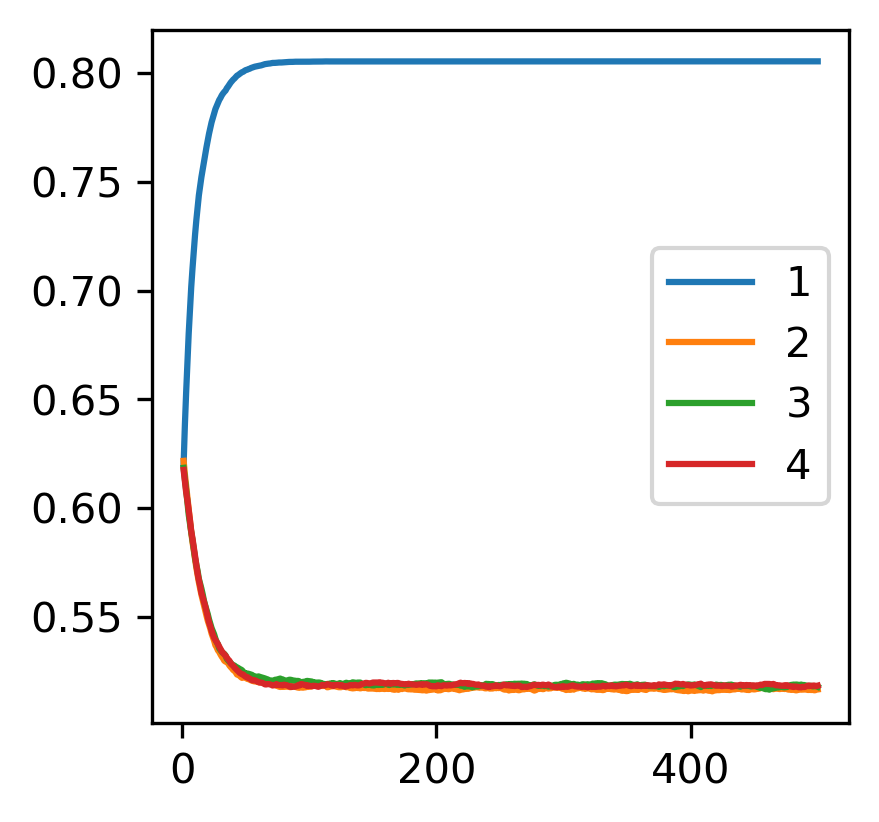

Python: <matplotlib.legend.Legend object at 0x156b88b10>

In [9]:
fig,ax = subplots(1,figsize=(3,3),dpi=300)
ax.plot(1:N_TimeSteps, prob_remember_stims[:,1], label = "1")
ax.plot(1:N_TimeSteps, prob_remember_stims[:,2], label = "2")
ax.plot(1:N_TimeSteps, prob_remember_stims[:,3], label = "3")
ax.plot(1:N_TimeSteps, prob_remember_stims[:,4], label = "4")

ax.legend()

In [11]:
# now run a simulation of experiment 1
function cowan_k(p_corr, num_obj)
   return num_obj .* (p_corr - (1 .- p_corr))
end



function sim_exp1(epsilon, N_Quanta, NT_per_Second)
    
    """
    d_all: is prob correct over time for 3 consitions
    row 1: precue
    row2: neutral
    row3: retrocue
    """
    
    N_Trials = 1000;
    
    N_Object_Vals = [2,4]

    # these are each 1 second, but question is how many model time-steps occur per real world second...
    N_TimeSteps_Pre = NT_per_Second
    N_TimeSteps_Post = NT_per_Second
    N_TimeSteps = N_TimeSteps_Pre + N_TimeSteps_Post

    d_all = zeros(3, length(N_Object_Vals), N_TimeSteps)

    for (obj_idx, N_Objects) in enumerate(N_Object_Vals)

        # pre-cue all time-steps are post
        d_precue = simulate_task(N_Quanta, N_Objects, epsilon, 0, N_TimeSteps, N_Trials, simulate_precue_episode);
        d_precue = d_precue[:,1]
        d_all[1,obj_idx,:] = d_precue

        # delayed memory - all time-steps are pre
        d_neutral = simulate_task(N_Quanta, N_Objects, epsilon, N_TimeSteps, 0, N_Trials, simulate_delayed_memory_episode);
        d_neutral = d_neutral[:,1]
        d_all[2,obj_idx,:] = d_neutral
        
        # retro-cue
        d_retro = simulate_task(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_retrocue_episode);
        d_retro = d_retro[:,1]
        d_all[3,obj_idx,:] = d_retro

    end
    
    return d_all
    
end


N_Quanta = 10
epsilon = .8
NT_per_Second = 500

d_all = sim_exp1(epsilon, N_Quanta, NT_per_Second);


In [12]:
# size(d_all)

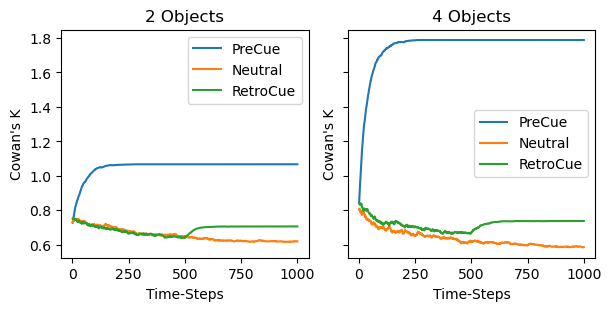

In [13]:
fig,ax = subplots(1, 2, figsize = (6,3), constrained_layout=true, sharey=true)

N_TimeSteps = 2*NT_per_Second

for (obj_idx, N_Objects) in enumerate([2,4])
    
    TS = 1:N_TimeSteps
    
    d_precue = cowan_k(d_all[1,obj_idx,:], N_Objects);
    ax[obj_idx-1].plot(TS, d_precue, label = "PreCue")
    
    d_neutral = cowan_k(d_all[2,obj_idx,:], N_Objects);
    ax[obj_idx-1].plot(TS, d_neutral, label = "Neutral")
    
    d_retro = cowan_k(d_all[3,obj_idx,:], N_Objects);
    ax[obj_idx-1].plot(TS, d_retro, label = "RetroCue")
    ax[obj_idx-1].legend()
    ax[obj_idx-1].set_xlabel("Time-Steps")
    
    ax[obj_idx-1].set_ylabel("Cowan's K")
    
    ax[obj_idx-1].set_title(string(N_Objects) * " Objects")

end

In [527]:
s = [1 , 1, 1]
# possible_S_prime, prob_S_prime= get_possible_s_prime_and_probs(s,1)

N_Objects = length(s)


legal_actions = findall(s.>0)
N_legal_actions = length(legal_actions)
Q = zeros(N_legal_actions)

for a_idx in 1:N_legal_actions
# a_idx = 1

    A = legal_actions[a_idx]

    possible_S_prime, prob_S_prime = get_possible_s_prime_and_probs(s,A)
    possible_R_prime = [get_state_reward(this_s, object_probe_probs, per_timestep_probe_prob) for this_s in possible_S_prime]

    Q[a_idx] = prob_S_prime'*possible_R_prime # just look to the next state
end
Q = round.(Q,digits=8)

# possible_R_prime = [get_state_reward(this_s, object_probe_probs, per_timestep_probe_prob) for this_s in possible_S_prime]
max_val = maximum(Q)

max_Q_idxs = findall(Q .== max_val)
max_actions = legal_actions[max_Q_idxs]

prob_actions_Q = zeros(N_Objects)
prob_actions_Q[max_actions] .= 1 ./ length(max_actions)   
#get_Pol_onestep_R(s, object_probe_probs, per_timestep_probe_prob, 0)

3-element view(::Vector{Float64}, [1, 2, 3]) with eltype Float64:
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333

In [462]:
round.(Q, digits = 8)

3-element Vector{Float64}:
 0.05869837
 0.05869837
 0.05869837

In [5]:
# using ExpFamilyDistributions

In [6]:
# Pkg.add("ExpFamilyDistributions")

In [7]:
get_possible_s_prime_and_probs(collect(s),A)

LoadError: UndefVarError: `A` not defined

In [8]:
using StatsBase
ProbabilityWeights([0.2, 0.1, 0.3])

3-element ProbabilityWeights{Float64, Float64, Vector{Float64}}:
 0.2
 0.1
 0.3

In [9]:
using StatsBase

function sample_simplex(N)
    # Generate N+1 random points
    points = rand(N+1, N)
    
    # Compute the barycentric coordinates
    weights = rand(N+1)
    weights /= sum(weights)
    
    # Sort the points based on the weights
    sorted_points = points[sortperm(weights), :]
    
    # Calculate the sample point using the normalized barycentric coordinates
    normalized_weights = weights / sum(weights)
    sample_point = sum(sorted_points .* normalized_weights, dims=1)
    
    return vec(sample_point)
end

# Example: Sampling from a 4-dimensional simplex
N = 3  # Change N to the desired dimension - 1
this_sample = sample_simplex(N)
println("Sample from a length-$N simplex: $this_sample")

Sample from a length-3 simplex: [0.6251407628176552, 0.36680193264504246, 0.5631340901948926]


In [10]:
sum(this_sample)

1.5550767856575902

In [11]:
this_sample

3-element Vector{Float64}:
 0.6251407628176552
 0.36680193264504246
 0.5631340901948926

In [12]:
N_Objects = 3
N_Quanta = 5
5/3

1.6666666666666667

In [14]:
using Random, Distributions

In [25]:
function sample_start_state(N_Objects, N_Quanta)

    d = Exponential()
    x = rand(d, 3)
    x = x/sum(x)
   
    return x
end

sample_start_state (generic function with 1 method)

In [26]:
x = sample_start_state(N_Objects, N_Quanta)

3-element Vector{Float64}:
 0.1197316527836375
 0.35485205438984213
 0.5254162928265205

In [55]:
sort(round.(x*N_Quanta))

3-element Vector{Float64}:
 1.0
 2.0
 3.0

In [24]:
N_Quanta

5

In [54]:

nums = sort(floor.((N_Quanta+1)*rand(N_Objects)))

x = zeros(N_Objects)
x[1] = nums[1]

for o in 2:N_Objects
    x[o] = nums[0]
    

3-element Vector{Float64}:
 2.0
 1.0
 2.0

In [120]:
function sample_integers_summing_to_x(N, X)
    
    # X is n quanta
    # Step 1: Generate N-1 random integers
    random_integers = rand(1:X, N-1)

    # Step 2: Sort the generated integers
    sort!(random_integers)

    # Step 3: Calculate the differences
    differences = [random_integers[1]; diff(random_integers); X - random_integers[end]]

    return shuffle(differences)
end

# Example usage:
N = 5
X = 20
result = sample_integers_summing_to_x(N, X)
shuffle(result)
sum(result)

20

In [121]:
result

5-element Vector{Int64}:
  2
  1
  1
  5
 11

In [100]:
length(result)

5

In [128]:
function sample_state(N_Objects, N_Quanta)
    
    # Step 1: Generate N-1 random integers
    random_integers = rand(1:N_Quanta, N_Objects-1)

    # Step 2: Sort the generated integers
    sort!(random_integers)
    print(random_integers)
    
    # Step 3: Calculate the differences
    differences = [random_integers[1]; diff(random_integers); N_Quanta - random_integers[end]]

    return shuffle(differences)
    
end

sample_state (generic function with 1 method)

In [141]:
sample_state(5,3)

[1, 1, 2, 3]

5-element Vector{Int64}:
 0
 1
 0
 1
 1